In [1]:
import pandas as pd
import os, sys, re
from urllib.request import Request, urlopen
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.api.types import CategoricalDtype

In [2]:
#get html data from website
url = "https://or.water.usgs.gov/non-usgs/bes/fernwood.rain"
url = "https://or.water.usgs.gov/non-usgs/bes/vernon.rain"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"}
req = Request(url, headers=headers)
html_page = urlopen(req).readlines()
#Many webmasters protect themselves from crawlers. They parse User-Agent header. So when they come across an User-Agent header like urllib/VVV, they think it's a crawler.
print(len(html_page))

9399


In [3]:
# html to data frame
data = html_page[11::]
data = [l.decode("utf-8").split('   ')[0:2] for l in data] 
df = pd.DataFrame(data, columns=['date','tips'])   # constructing dataframe
df.tips.replace('  -',np.nan,inplace=True)
df['inches'] = df.tips.astype('float') * 0.01
df['year'] = [int(item.split('-')[2]) for item in df.date]
df['month'] = [item.split('-')[1] for item in df.date]
df['day'] = [item.split('-')[0] for item in df.date]
df['mmm_dd'] = df['month'] + '_' + df['day']
df['yr_mm'] = df['year'].astype('str') + '_' + df['month']

In [9]:
#calculate monthly totals, historical averages
cutoff = 2021
s = pd.Series(['JAN','FEB','MAR','APR', 'MAY','JUN', 'JUL', 'AUG', 'SEP','OCT', 'NOV','DEC'])
cat_type = CategoricalDtype(categories=s,ordered=True)
df_month = df[df.year>cutoff].groupby('yr_mm').sum(numeric_only=True).reset_index()
df_month.drop('year',axis=1,inplace=True)
df_month['year'] = [item.split('_')[0] for item in df_month.yr_mm]
df_month['month'] = [item.split('_')[1] for item in df_month.yr_mm]
df_month['month'] =  df_month['month'].astype(cat_type)
#historical
df_history = df[df.year<=cutoff].groupby('yr_mm').sum(numeric_only=True).reset_index()
df_history.drop('year',axis=1,inplace=True)
df_history['year'] = [item.split('_')[0] for item in df_history.yr_mm]
df_history['month'] = [item.split('_')[1] for item in df_history.yr_mm]
df_history['month'] =  df_history['month'].astype(cat_type)

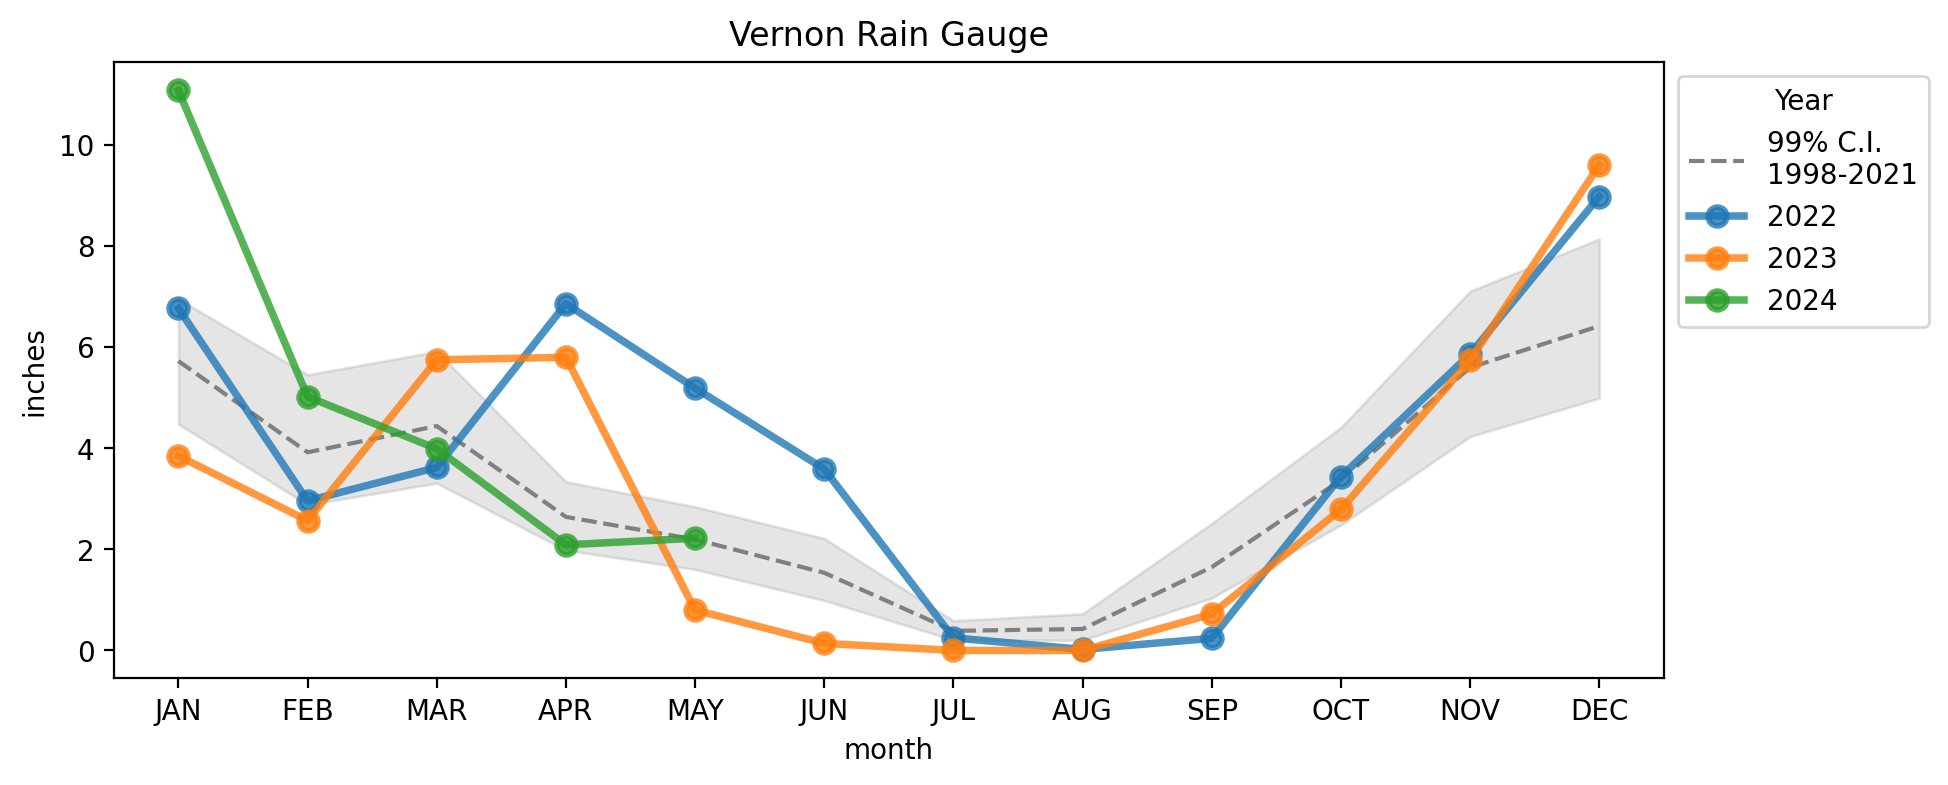

In [10]:
#plot
fig,ax = plt.subplots(dpi=200,figsize=(10,4))
sns.lineplot(data=df_history, x="month", y="inches",ax=ax,label=f'99% C.I.\n{df_history.year.min()}-{df_history.year.max()}',
             color='gray',linestyle='--',errorbar=('ci', 99))
sns.pointplot(data=df_month, x="month", y="inches", hue="year",alpha=0.8,ax=ax)
ax.set_title(f"{url.split('/')[-1].replace('.',' ').title()} Gauge")
ax.legend(bbox_to_anchor=(1,1),title='Year')
fig.savefig('rain.png')

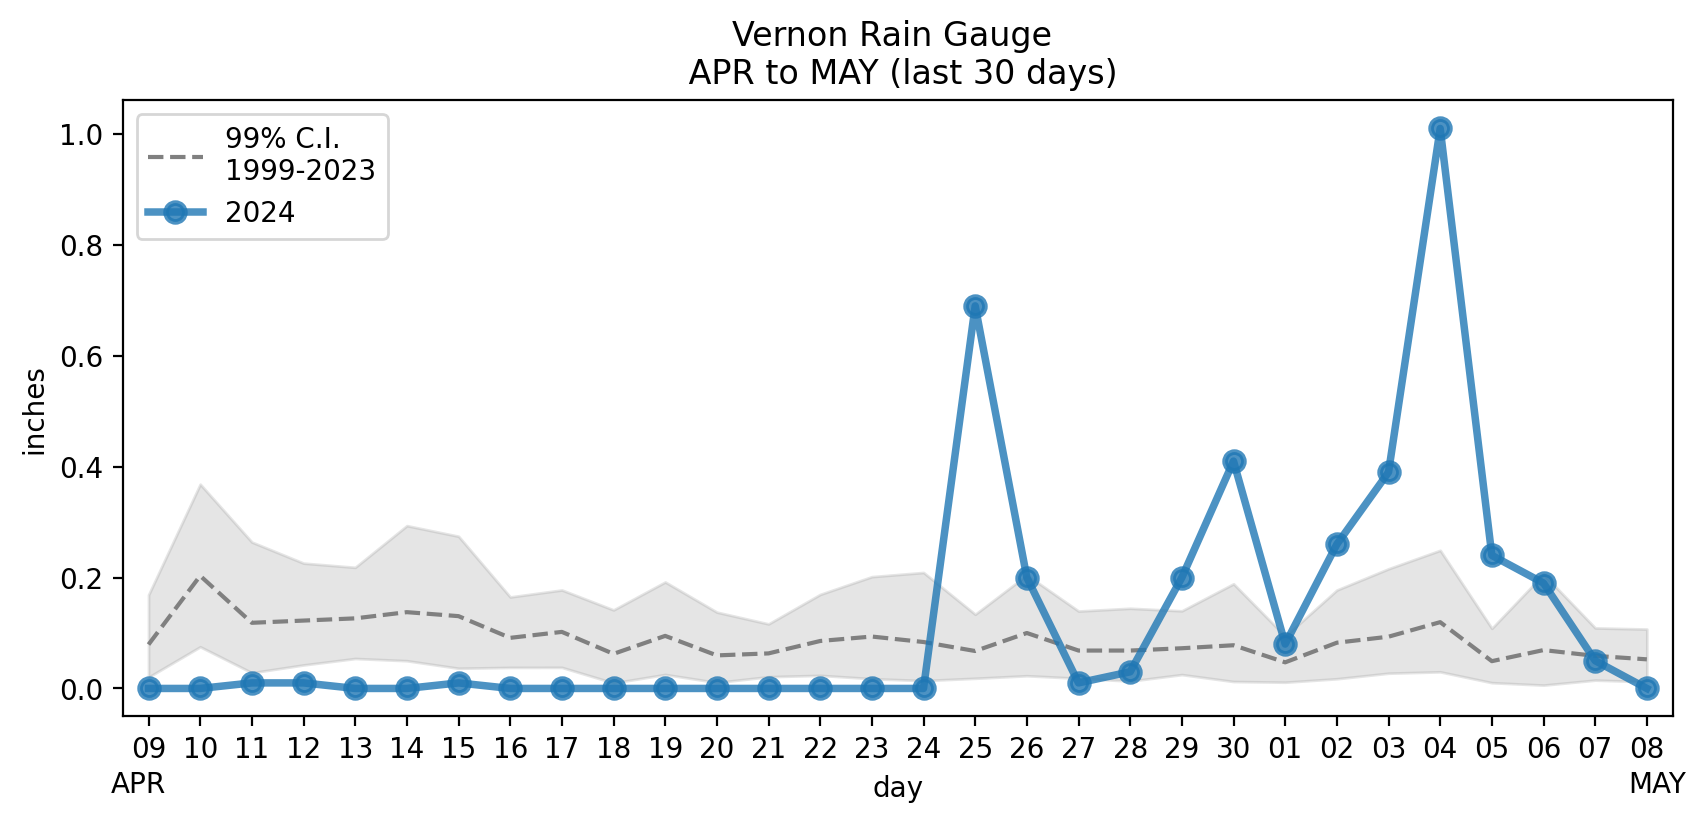

In [13]:
#last 30 days
cutoff = 2023
month_len = 30
df_current_month = df.iloc[0:month_len][::-1].copy()
s_months = (' to ').join(list(df_current_month.month.unique()))
df_current_history = df[(df.year<=cutoff) & df.mmm_dd.isin(df_current_month.mmm_dd)].copy()
df_current_history['day'] = [item.split('_')[1] for item in df_current_history.mmm_dd]

#order days
s_day = pd.Series(df_current_month.day.tolist())
cat_type_day = CategoricalDtype(categories=s_day,ordered=True)
df_current_history['day'] =  df_current_history['day'].astype(cat_type_day)

#plot
fig,ax = plt.subplots(dpi=200,figsize=(10,4))
sns.lineplot(data=df_current_history, x="day", y="inches",ax=ax,label=f'99% C.I.\n{df_current_history.year.min()}-{df_current_history.year.max()}',
             color='gray',linestyle='--',errorbar=('ci', 99))#
sns.pointplot(data=df_current_month, x="day", y="inches", alpha=0.8,ax=ax,label=df_current_month.year[0])#hue="year",#,order=
ax.set_title(f"{url.split('/')[-1].replace('.',' ').title()} Gauge \n {s_months} (last {month_len} days)")
#ax.legend(bbox_to_anchor=(1,1),title='Year')
#ax.set_xticklabels(df_current_month.day)
# #add months
ax.text(0.01, -0.11, df_current_month.loc[month_len-1,'month'], horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
ax.text(0.99, -0.11, df_current_month.loc[0,'month'] , horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
fig.savefig('rain_current_month.png')